In [7]:
from epyt import epanet
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Create a function to run the simulation and return the pressure results
def compute_bounds(G, nsim, base_demands, eta_bar, node_index):
    # Seed number to always get the same random results
    np.random.seed(1)
    # Initialize matrix to save MCS pressures
    pmcs = [None for _ in range(nsim)]
    for i in range(nsim):
        # Compute new base demands
        delta_bd = (2 * np.random.rand(1, len(base_demands))[0] - 1) * eta_bar * base_demands
        new_base_demands = base_demands + delta_bd
        # Set base demands
        G.setNodeBaseDemands(new_base_demands)
        # Compute pressures at each node
        pmcs[i] = G.getComputedHydraulicTimeSeries().Pressure
        print(f"Epoch {i}")

    # Compute upper and lower bounds
    pmulti = []
    for i in range(nsim):
        pmulti.append(pmcs[i][:, node_index - 1])
    pmulti = np.vstack(pmulti)
    ub = np.max(pmulti, axis=0)
    lb = np.min(pmulti, axis=0)
    meanb = np.mean(pmulti, axis=0)

    return pmulti, ub, lb, meanb

In [9]:
def activate_PDA(G):
    type = 'PDA'
    pmin = 0
    preq = 0.1
    pexp = 0.5
    G.setDemandModel(type, pmin, preq, pexp)  # Sets the demand model


In [10]:
if __name__ == "__main__":

    # Prepare network for Monte Carlo Simulations
    # Load network
    inp_name = 'Net2.inp'  # 'L-TOWN.inp'
    G = epanet(inp_name)
    # Pressure driven analysis
    activate_PDA(G)

EPANET version 20200 loaded (EPyT version 1.0.6).
Input File Net2.inp loaded successfully.



In [11]:
    # Get nominal base demands
    base_demands = G.getNodeBaseDemands()[1]
    print(base_demands)

[-694.4     8.     14.      8.      8.      5.      4.      9.     14.
    5.     34.78   16.      2.      2.      2.     20.     20.     20.
    5.     19.     16.     10.      8.     11.      6.      8.      0.
    7.      3.     17.     17.      1.5     1.5     0.      1.      0.  ]


In [12]:
    # Number of simulations
    nsim = 100
    # Pressure Simulations at Node 5
    node_id = '11'
    node_index = G.getNodeIndex(node_id)
    # 5% max uncertainty in base demands
    eta_bar = 0.02
    pmulti, ub, lb, meanb = compute_bounds(G, nsim, base_demands, eta_bar, node_index)
    print(pmulti, ub, lb, meanb)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
[[48.0734592  48.79156405 49.46221676 ... 50.20541151 50.8701437
  51.19999367]
 [48.11716984 48.85268765 49.5

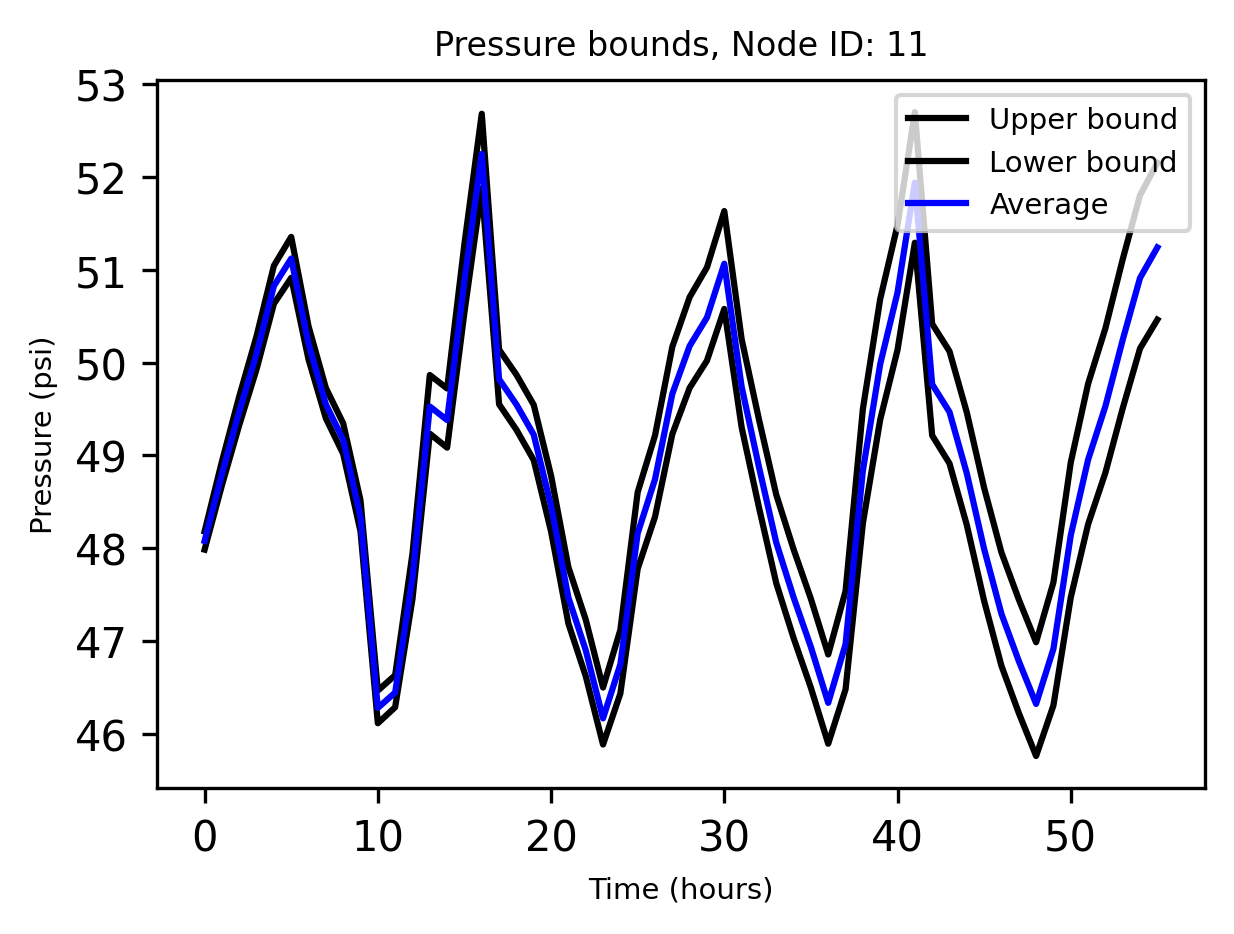

In [13]:
    # Plots
    pressure_units = G.units.NodePressureUnits
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(ub, 'k')
    ax.plot(lb, 'k')
    ax.plot(meanb, 'b')
    ax.legend(['Upper bound', 'Lower bound', 'Average'], loc='upper right', fontsize=7)
    ax.set_title(f'Pressure bounds, Node ID: {node_id}', fontsize=8)
    ax.set_xlabel('Time (hours)', fontsize=7)
    ax.set_ylabel(f'Pressure ({pressure_units})', fontsize=7)
    plt.show()
    fig.savefig('figures/paper_pressure_bounds.png', dpi=300)

In [14]:
    # Add leakage at Node ID 7 after 20 hours
    leak_scenario = 50
    leak_start = 20
    leak_value = 50  # GPM unit
    leak_node_id = '7'
    leak_node_index = G.getNodeIndex(leak_node_id)
    leak_pattern = np.zeros(max(G.getPatternLengths()))
    leak_pattern[leak_start:] = 1
    pattern_index = G.addPattern('leak', leak_pattern)
    G.setNodeDemandPatternIndex(leak_node_index, pattern_index)
    G.setNodeBaseDemands(leak_node_index, leak_value)

In [15]:
    # Compute pressures
    scada_pressures = G.getComputedHydraulicTimeSeries().Pressure

In [16]:
    p7 = scada_pressures[:, node_index-1]
    e = p7 - lb
    alert = e < 0
    detectionTime = np.argmax(alert>1)

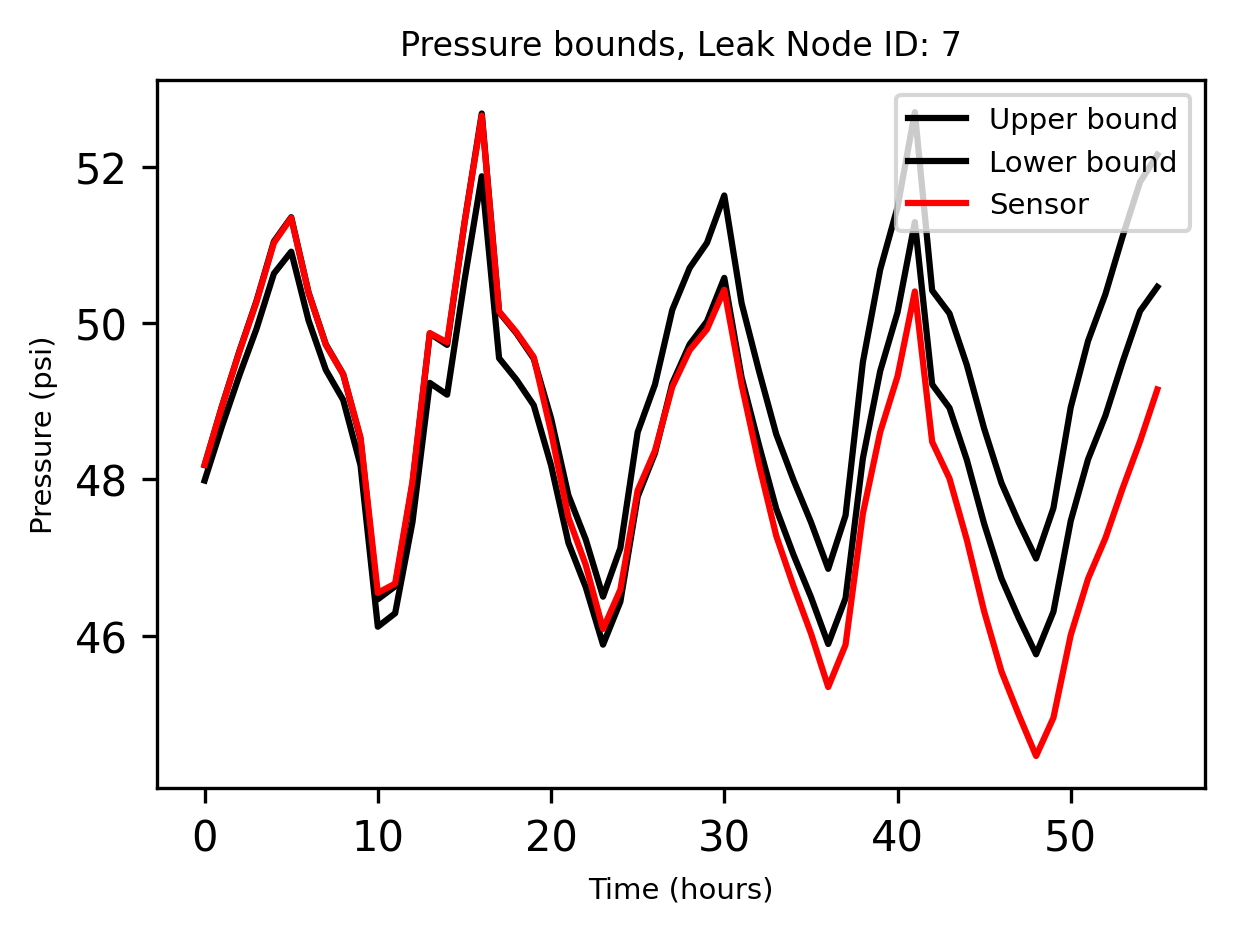

In [17]:
    # Bounds with Leakage
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(ub, 'k')
    ax.plot(lb, 'k')
    ax.plot(p7, 'r')
    ax.legend(['Upper bound', 'Lower bound', 'Sensor'], loc='upper right', fontsize=7)
    ax.set_title(f'Pressure bounds, Leak Node ID: {leak_node_id}', fontsize=8)
    ax.set_xlabel('Time (hours)', fontsize=7)
    ax.set_ylabel(f'Pressure ({pressure_units})', fontsize=7)
    plt.show()
    fig.savefig('figures/paper_pressure_bounds_leak.png', dpi=300)

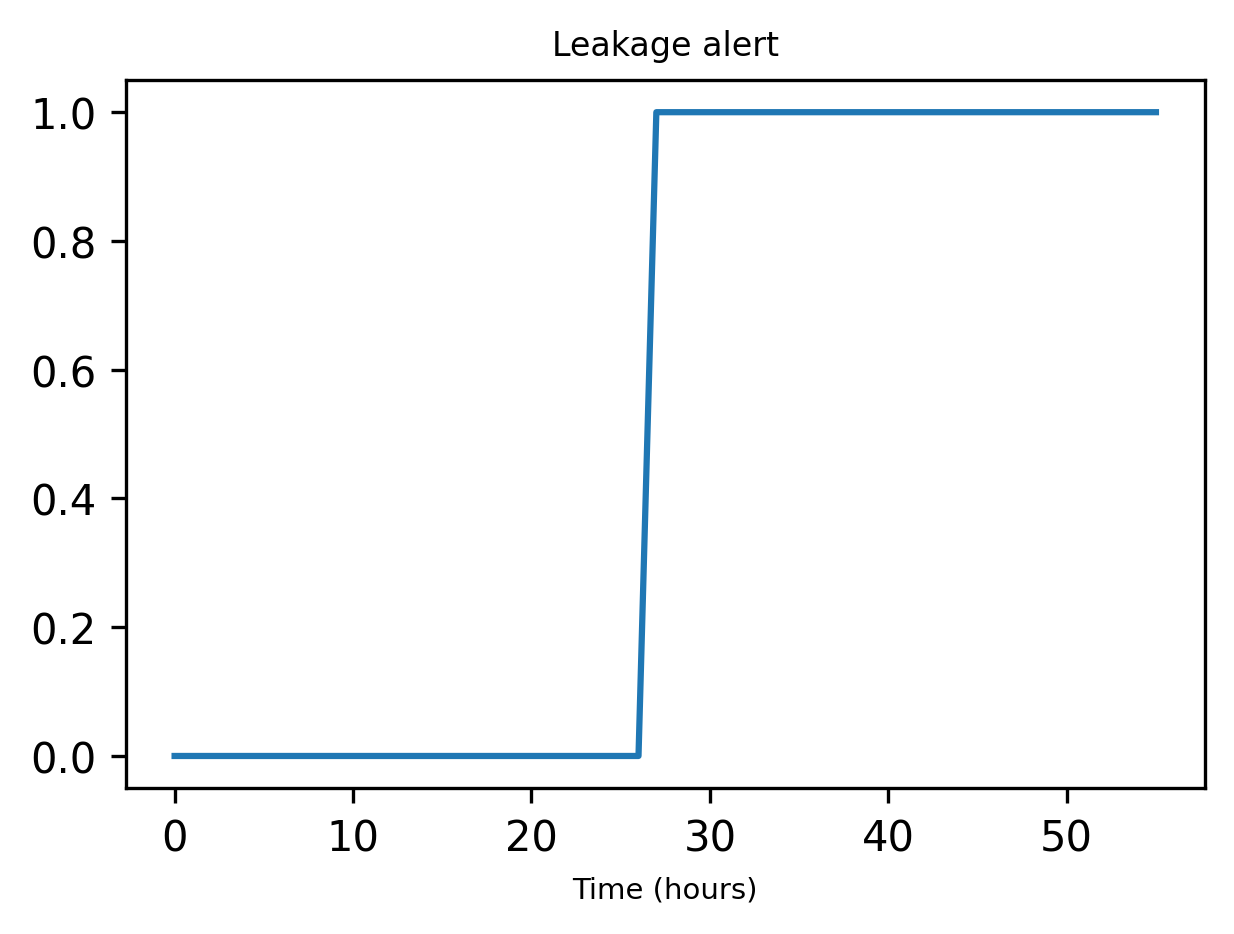

In [18]:
    # Leakage alert
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(alert)
    ax.set_title(f'Leakage alert', fontsize=8)
    ax.set_xlabel('Time (hours)', fontsize=7)
    plt.show()
    fig.savefig('figures/paper_leakage_alert.png', dpi=300)